In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image, ImageOps
import collections
import bcolz
import time
import sys

plt.ion()

In [2]:
print(sys.version)
print("PyTorch version: %s" % torch.version.__version__)

3.5.3 |Continuum Analytics, Inc.| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
PyTorch version: 0.1.12_2


## Download data

In [42]:
data_dir = "data/"

In [25]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [9]:
%cd $data_dir

/root/learn-dl/convolution/data


In [4]:
!curl -L -O http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar
!tar -xf 256_ObjectCategories.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1128M  100 1128M    0     0  19.2M      0  0:00:58  0:00:58 --:--:-- 20.4M0  0:01:17  0:00:03  0:01:14 14.6M


In [11]:
os.mkdir("Caltech256")
for dataset in ['train', 'test', 'valid']:
    os.mkdir("Caltech256/%s/" % dataset)

In [13]:
!find ./256_ObjectCategories/ -regextype posix-extended -type f -regex ".*/[0-9][0-9][0-9]\..+" -print | shuf | head -n 5000 | xargs -I {} mv {} ./Caltech256/valid/
!find ./256_ObjectCategories/ -regextype posix-extended -type f -regex ".*/[0-9][0-9][0-9]\..+" -print | shuf | head -n 6000 | xargs -I {} mv {} ./Caltech256/test/
!find ./256_ObjectCategories/ -regextype posix-extended -type f -regex ".*/[0-9][0-9][0-9]\..+" -print | xargs -I {} mv {} ./Caltech256/train/
!find ./256_ObjectCategories/ -regextype posix-extended -type d -regex ".*/[0-9][0-9][0-9]\..+" -delete

shuf: write error: Broken pipe
shuf: write error
shuf: write error: Broken pipe
shuf: write error


In [17]:
%cd ..

/root/learn-dl/convolution


In [35]:
def structure_dir(dir_name):
    for i in range(1, 258):
        os.mkdir("%s/%s" % (dir_name, i))
    for f in os.listdir(dir_name):
        if 'jpg' in f:
            d = int(f.split("_")[0])
            a = dir_name + "/" + f
            b = dir_name + "/" + str(d) + "/" + f
            os.rename(a, b)

In [36]:
structure_dir(data_dir + 'Caltech256/' + 'valid')
structure_dir(data_dir + 'Caltech256/' + 'train')
structure_dir(data_dir + 'Caltech256/' + 'test')

## Load and rescale images

Load the VGG16 model from the torchvision package

In [37]:
model_conv = torchvision.models.vgg16(pretrained=True)

The new scale transform isn't in the latest pytorch release, so define it here

In [38]:
class MyScale(object):
    """Rescales the input PIL.Image to the given 'size'.
    If 'size' is a 2-element tuple or list in the order of (width, height), it will be the exactly size to scale.
    If 'size' is a number, it will indicate the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the exactly size or the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        if isinstance(self.size, int):
            w, h = img.size
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return img
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
                return img.resize((ow, oh), self.interpolation)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return img.resize((ow, oh), self.interpolation)
        else:
            return img.resize(self.size, self.interpolation)

Only rescaling to 224x224 and converting to tensor here, can do more complex things like normalizing to improve performance in the future.

In [43]:
data_dir += 'Caltech256/'

In [44]:
data_transform = transforms.Compose([MyScale((224, 224)), transforms.ToTensor()])
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform)
         for x in ['train', 'test', 'valid']}
batch_size = 32
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                for x in ['train', 'test', 'valid']}
dset_classes = dsets['train'].classes

You can define your own model by extending the `nn.Module` class. Just define any attributes you wish to use, and implement the `forward` method which passes a tensor through your model.

In [48]:
class VGGFeaturize(nn.Module):
    def __init__(self):
        super(VGGFeaturize, self).__init__()
        self.features = model_conv.features
        self.classifier = model_conv.classifier
    def forward(self, x):
        x = self.features(x)
        return x.resize(x.size()[0], 25088)

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

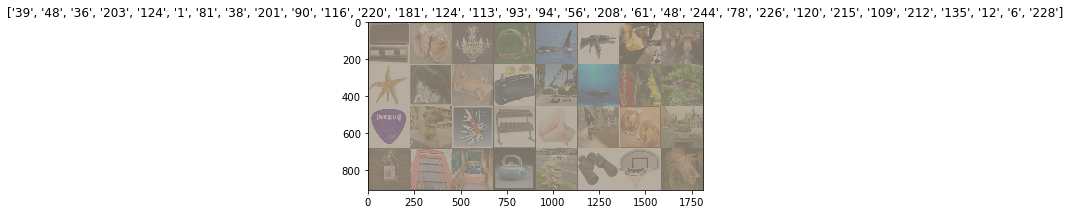

In [47]:
inputs, classes = next(iter(dset_loaders['valid']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dset_classes[x] for x in classes])

PyTorch is more straightforward/explicit about what is happening. If you want a model/tensor to be stored on the GPU,
then call `.cuda()` on it. To transfer it back to the cpu, call `.cpu()`.

In [49]:
model = VGGFeaturize().cuda()

## Featurize the data

**Only do this once! Then use the saved bcolz arrays**

In [50]:
def featurize(dataset):
    feature_batches = []
    label_batches = []
    for data in dataset:
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        output = model(inputs)
        feature_batches.extend(output.data.cpu().numpy())
        label_batches.extend(labels.data.cpu().numpy())
    features_stacked = np.concatenate([[feat] for feat in feature_batches])
    return features_stacked, label_batches

In [51]:
def featurize_and_save(data_label, base_dir):
    feat, label = featurize(dset_loaders[data_label])
    c_feat = bcolz.carray(feat, rootdir=save_path + 'conv_%s_feat.dat' % data_label)
    c_feat.flush()
    c_label = bcolz.carray(label, rootdir=save_path + 'conv_%s_label.dat' % data_label)
    c_label.flush()
    print("Saved %s images for %s phase" % (c_feat.shape[0], data_label))

In [55]:
if not os.path.exists(data_dir + 'featurized/'):
    os.makedirs(data_dir + 'featurized/')
save_path = data_dir + 'featurized/'

In [56]:
featurize_and_save('valid', save_path)
featurize_and_save('train', save_path)
featurize_and_save('test', save_path)

Saved 5000 images for valid phase
Saved 19608 images for train phase
Saved 5999 images for test phase


## Define data loaders to grab the featurized data

In [57]:
class BcolzDataset(torch.utils.data.Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        return torch.from_numpy(self.features[index]), self.labels[index]

    def __len__(self):
        return self.features.shape[0]

In [58]:
dsets = {x: BcolzDataset(bcolz.open(save_path + 'conv_%s_feat.dat' % x), bcolz.open(save_path + 'conv_%s_label.dat' % x))
         for x in ['train', 'test', 'valid']}
batch_size = 16
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                for x in ['train', 'test', 'valid']}

This is where we train and evaluate the model. This is mostly copied from a PyTorch example. Keras does this type of thing for you, and you only need to call `fit`. Since PyTorch is mostly just a Tensor library, things are more straightforward and it's not hard to just code this up yourself.

In [59]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model = model
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            for data in dset_loaders[phase]:
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [60]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}

Create a model that has frozen the classifier layers, but replaced the last linear layer to output 257 classes. Then training is very straightforward - just compute backwards pass through the last layer.

In [61]:
layers = []
for i in range(6):
    layer = model_conv.classifier[i]
    layers.append(layer)
model = nn.Sequential(*layers)
for m in model.parameters():
    m.requires_grad = False
model.add_module('predictions', nn.Linear(4096, 257))
model = model.cuda()

In [62]:
optimizer = torch.optim.Adam(model.predictions.parameters(), lr=0.0001)  # only pass in parameters that will be optimized
criterion = nn.CrossEntropyLoss()
best_model = train_model(model, criterion, optimizer, 5)

Epoch 0/4
----------
train Loss: 0.1607 Acc: 0.4838
valid Loss: 0.0999 Acc: 0.6690

Epoch 1/4
----------
train Loss: 0.0814 Acc: 0.7048
valid Loss: 0.0827 Acc: 0.7000

Epoch 2/4
----------
train Loss: 0.0664 Acc: 0.7452
valid Loss: 0.0763 Acc: 0.7122

Epoch 3/4
----------
train Loss: 0.0579 Acc: 0.7731
valid Loss: 0.0724 Acc: 0.7174

Epoch 4/4
----------
train Loss: 0.0514 Acc: 0.7975
valid Loss: 0.0699 Acc: 0.7268

Training complete in 1m 22s
Best val Acc: 0.726800


In [63]:
optimizer = torch.optim.Adam(model.predictions.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
best_model = train_model(model, criterion, optimizer, 5)

Epoch 0/4
----------
train Loss: 0.0451 Acc: 0.8236
valid Loss: 0.0690 Acc: 0.7312

Epoch 1/4
----------
train Loss: 0.0442 Acc: 0.8266
valid Loss: 0.0688 Acc: 0.7324

Epoch 2/4
----------
train Loss: 0.0434 Acc: 0.8289
valid Loss: 0.0686 Acc: 0.7318

Epoch 3/4
----------
train Loss: 0.0432 Acc: 0.8260
valid Loss: 0.0685 Acc: 0.7316

Epoch 4/4
----------
train Loss: 0.0427 Acc: 0.8311
valid Loss: 0.0682 Acc: 0.7334

Training complete in 1m 23s
Best val Acc: 0.733400


## Let's try training all the classification layers

In [64]:
layers = []
for i in range(6):
    layer = model_conv.classifier[i]
    layers.append(layer)
model = nn.Sequential(*layers)
for m in model.parameters():
    m.requires_grad = True
model.add_module('predictions', nn.Linear(4096, 257))
model = model.cuda()

In [65]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # only pass in parameters that will be optimized
criterion = nn.CrossEntropyLoss()
best_model = train_model(model, criterion, optimizer, 3)

Epoch 0/2
----------
train Loss: 0.1402 Acc: 0.4922
valid Loss: 0.0815 Acc: 0.6752

Epoch 1/2
----------
train Loss: 0.0523 Acc: 0.7754
valid Loss: 0.0737 Acc: 0.7046

Epoch 2/2
----------
train Loss: 0.0220 Acc: 0.8983
valid Loss: 0.0788 Acc: 0.7056

Training complete in 6m 26s
Best val Acc: 0.705600
